# Step 1: Data Download and organization
 Please see the Project Proposal in the repo for information on goals, data sources, and research questions. 

This notebook is the first step in Kealie Pretzlav's Springboard Capstone 2 project. 
This notebook downloads the appropriate datasets, merges them, and checks for missing values and duplicates. 
Further data processing will occur in future steps. 

In [3]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv
import requests

## Flood Data
Flood occurence dataset from NOAA National Center for Environmental Information: https://www.ncdc.noaa.gov/stormevents/
Analysis uses storms which are labeled "Flood" or "Flash Flood". The database also includes other storm events such as tornados, hurricanes, and wind. 

Data is downloaded for 1996 to present; data is not available prior to 1996. 

In [4]:
### download storm data
storm_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
file_list = list(pd.read_html(storm_url, skiprows=2)[0]['Parent Directory'].dropna())
years_to_dl = range(1996, 2022, 1) ##download data for 1996 on, no flood data prior
filename_to_dl = [f for f in file_list if 'details-ftp_v1.0_d' in f]

##initialize data subset rather than downloading whole storm event dataset
df_flood = pd.DataFrame()
flood_types = ['Flood', 'Flash Flood']

for year in years_to_dl:
    filename = [s for s in file_list if 'details-ftp_v1.0_d' + str(year) in s][0]
    df_flood_year = pd.read_csv(storm_url + filename, dtype='object')
    df_flood = pd.concat([df_flood, df_flood_year[df_flood_year['EVENT_TYPE'].isin(flood_types)]])
    # print(year)

df_flood.head()

BEGIN_YEARMONTH BEGIN_DAY BEGIN_TIME END_YEARMONTH END_DAY END_TIME  \
1           199610        21        900        199610      21      900   
25          199601        24       1200        199601      24     1200   
34          199601        22        700        199601      31     1159   
44          199601        26       2330        199601      27      630   
69          199601        19        830        199601      20      700   

   EPISODE_ID EVENT_ID           STATE STATE_FIPS  ... END_RANGE END_AZIMUTH  \
1     2052748  5570362        OKLAHOMA         40  ...       NaN         NaN   
25    1000569  5536059         INDIANA         18  ...       NaN         NaN   
34    1002242  5549485        KENTUCKY         21  ...       NaN         NaN   
44    2404288  5537263  NORTH CAROLINA         37  ...       NaN         NaN   
69    2057213  5583210        NEW YORK         36  ...       NaN         NaN   

   END_LOCATION BEGIN_LAT BEGIN_LON END_LAT END_LON  \
1        DURANT       NaN       NaN     NaN     NaN   
25          NaN       NaN       NaN     NaN     NaN   
34          NaN       NaN       NaN     NaN     NaN   
44          NaN       NaN       NaN     NaN     NaN   
69   COUNTYWIDE       NaN       NaN     NaN     NaN   

                                    EPISODE_NARRATIVE EVENT_NARRATIVE  \
1   Flash flood waters washed out a small bridge a...             NaN   
25  On the 23rd, many areas received around an inc...             NaN   
34  Snowmelt and heavy rain caused widespread floo...             NaN   
44  Prolonged rain became heavier following the ic...             NaN   
69                                                NaN             NaN   

   DATA_SOURCE  
1          PDC  
25         PDC  
34         PDC  
44         PDC  
69         PDC  

[5 rows x 51 columns]

In [5]:
#view the data
df_flood.head().T

1   \
BEGIN_YEARMONTH                                                199610   
BEGIN_DAY                                                          21   
BEGIN_TIME                                                        900   
END_YEARMONTH                                                  199610   
END_DAY                                                            21   
END_TIME                                                          900   
EPISODE_ID                                                    2052748   
EVENT_ID                                                      5570362   
STATE                                                        OKLAHOMA   
STATE_FIPS                                                         40   
YEAR                                                             1996   
MONTH_NAME                                                    October   
EVENT_TYPE                                                Flash Flood   
CZ_TYPE                                                             C   
CZ_FIPS                                                            13   
CZ_NAME                                                         BRYAN   
WFO                                                               OUN   
BEGIN_DATE_TIME                                    21-OCT-96 09:00:00   
CZ_TIMEZONE                                                       CST   
END_DATE_TIME                                      21-OCT-96 09:00:00   
INJURIES_DIRECT                                                     0   
INJURIES_INDIRECT                                                   0   
DEATHS_DIRECT                                                       0   
DEATHS_INDIRECT                                                     0   
DAMAGE_PROPERTY                                                   NaN   
DAMAGE_CROPS                                                      NaN   
SOURCE                                                            NaN   
MAGNITUDE                                                         NaN   
MAGNITUDE_TYPE                                                    NaN   
FLOOD_CAUSE                                                       NaN   
CATEGORY                                                          NaN   
TOR_F_SCALE                                                       NaN   
TOR_LENGTH                                                        NaN   
TOR_WIDTH                                                         NaN   
TOR_OTHER_WFO                                                     NaN   
TOR_OTHER_CZ_STATE                                                NaN   
TOR_OTHER_CZ_FIPS                                                 NaN   
TOR_OTHER_CZ_NAME                                                 NaN   
BEGIN_RANGE                                                       NaN   
BEGIN_AZIMUTH                                                     NaN   
BEGIN_LOCATION                                                 DURANT   
END_RANGE                                                         NaN   
END_AZIMUTH                                                       NaN   
END_LOCATION                                                   DURANT   
BEGIN_LAT                                                         NaN   
BEGIN_LON                                                         NaN   
END_LAT                                                           NaN   
END_LON                                                           NaN   
EPISODE_NARRATIVE   Flash flood waters washed out a small bridge a...   
EVENT_NARRATIVE                                                   NaN   
DATA_SOURCE                                                       PDC   

                                                                   25  \
BEGIN_YEARMONTH                                                199601   
BEGIN_DAY                                                          24   
BEGIN_TIME                                         

In [132]:
## take a look at flood causes
df_flood.describe().T
df_flood['FLOOD_CAUSE'].value_counts()

(153990, 40)


KeyError: 'FLOOD_CAUSE'

In [7]:
##change col names to lowercase
df_flood.columns = df_flood.columns.str.lower()
df_flood.columns


Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [133]:
print(df_flood.shape)


(153990, 40)


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_2661/2766726960.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')


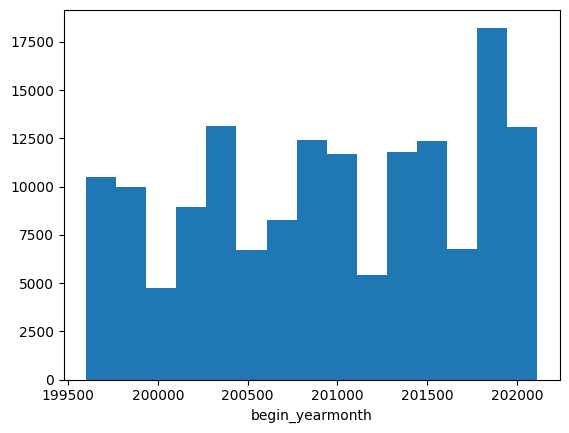

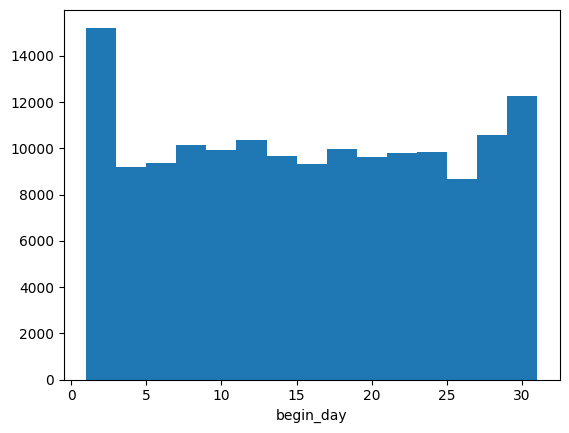

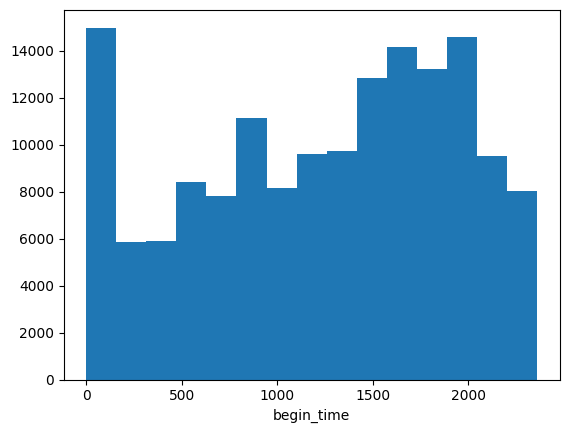

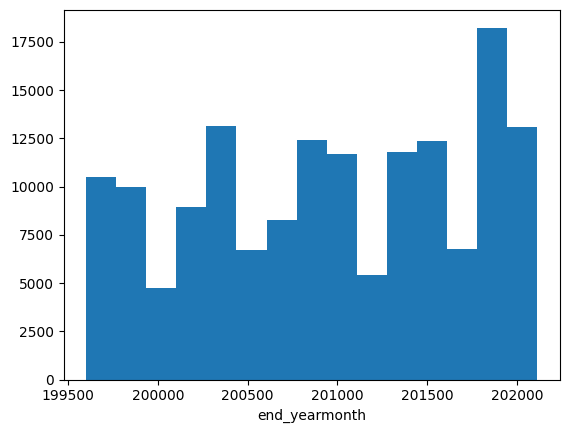

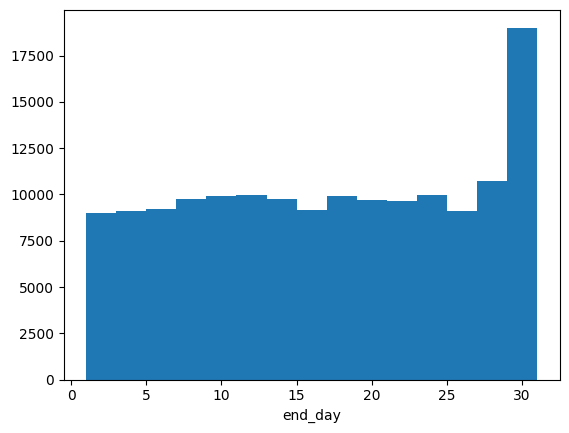

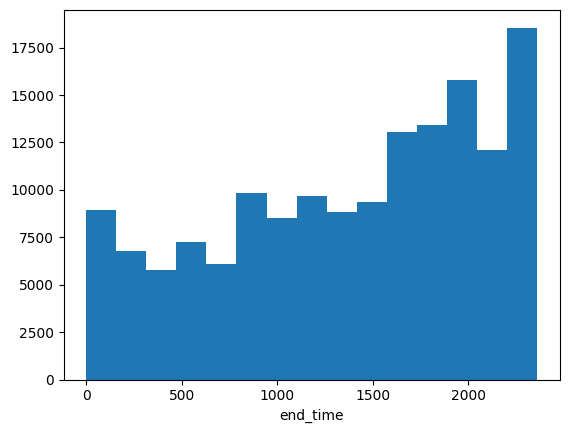

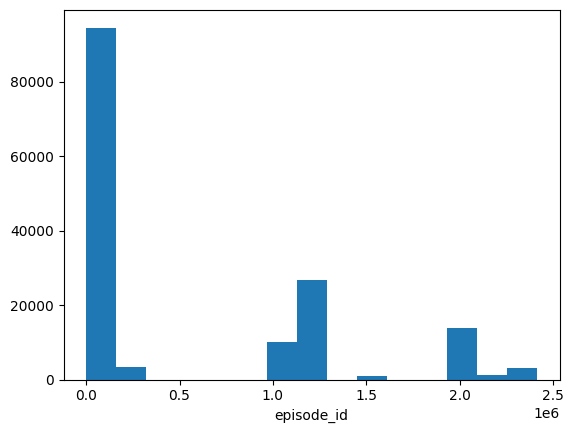

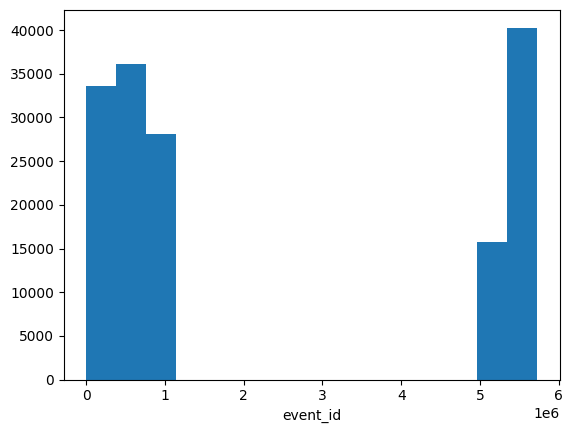

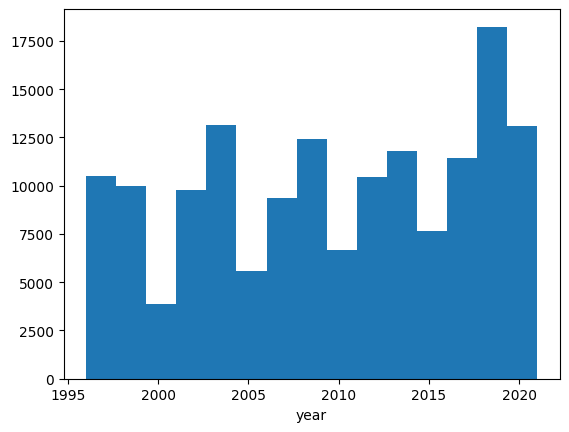

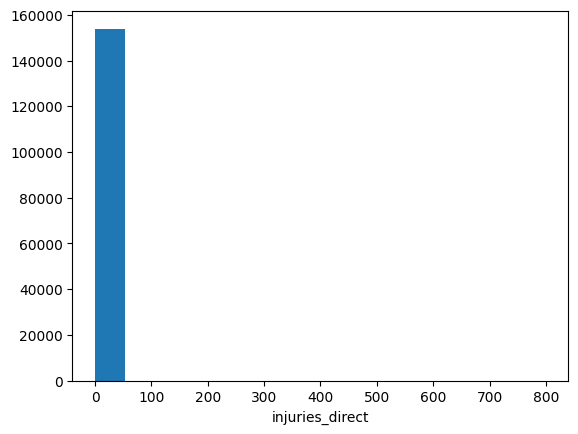

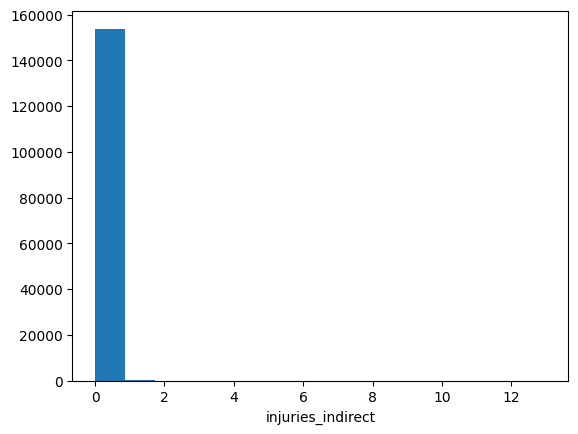

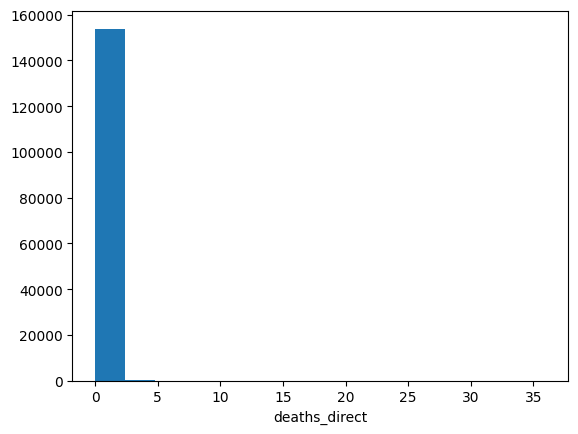

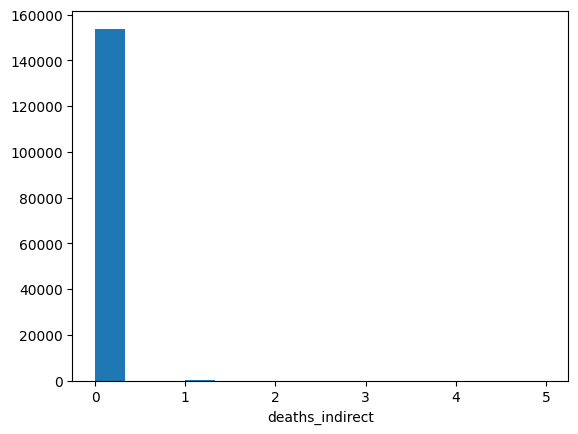

In [8]:
##check for outliers
flood_numeric_names = ['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
                       'end_day', 'end_time', 'episode_id', 'event_id','year',
                       'injuries_direct', 'injuries_indirect', 'deaths_direct','deaths_indirect']
df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')
### check numeric outliers
for n in df_flood[flood_numeric_names].columns:
    plt.hist(df_flood[flood_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()



_Things to notice about histograms/outliers_
- Time start and day start suggests a slight bias toward the start/end day and first/end time, suggesting unknown data uses these as defaults
- outlier on injuries_direct, injuries_indirect, deaths_direct, deaths_indirect. Unsure if that is real or unknown data. Appears as though many events just have missing injuries/death data. 


In [9]:
##check for missing values in key columns
df_flood.isna().sum()

begin_yearmonth            0
begin_day                  0
begin_time                 0
end_yearmonth              0
end_day                    0
end_time                   0
episode_id                 0
event_id                   0
state                      0
state_fips                 0
year                       0
month_name                 0
event_type                 0
cz_type                    0
cz_fips                    0
cz_name                    0
wfo                        0
begin_date_time            0
cz_timezone                0
end_date_time              0
injuries_direct            0
injuries_indirect          0
deaths_direct              0
deaths_indirect            0
damage_property        35527
damage_crops           49988
source                 13380
magnitude             153892
magnitude_type        153989
flood_cause            56070
category              153990
tor_f_scale           153990
tor_length            153990
tor_width             153990
tor_other_wfo 

Lots of columns have mostly missing data. Drop columns with more than 100k missing values (tor_ columns are for tornado events). Also drop columns that aren't needed. 

In [10]:
### done need all the data, drop some now to clean up
df_flood = df_flood.dropna(thresh=100000, axis=1)
df_flood_drop = df_flood.drop(['begin_range', 'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth', 'end_location'], axis=1)
##
df_flood_drop.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'begin_lat', 'begin_lon', 'end_lat', 'end_lon', 'episode_narrative',
       'event_narrative', 'data_source'],
      dtype='object')

Lat/Long has lots of missing values. How many have both begin and end lat or long missing? 

In [11]:
print('lat counts: ', df_flood_drop[['begin_lat', 'end_lat']].isna().sum(1).value_counts())
print('lon counts: ', df_flood_drop[['begin_lon', 'end_lon']].isna().sum(1).value_counts())
print('all lat/long counts: ', df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1).value_counts())

lat counts:  0    103535
2     50455
Name: count, dtype: int64
lon counts:  0    103535
2     50455
Name: count, dtype: int64
all lat/long counts:  0    103535
4     50455
Name: count, dtype: int64


50k are missing all lat/long info. Isolated to older data? Specific state?

<Axes: >

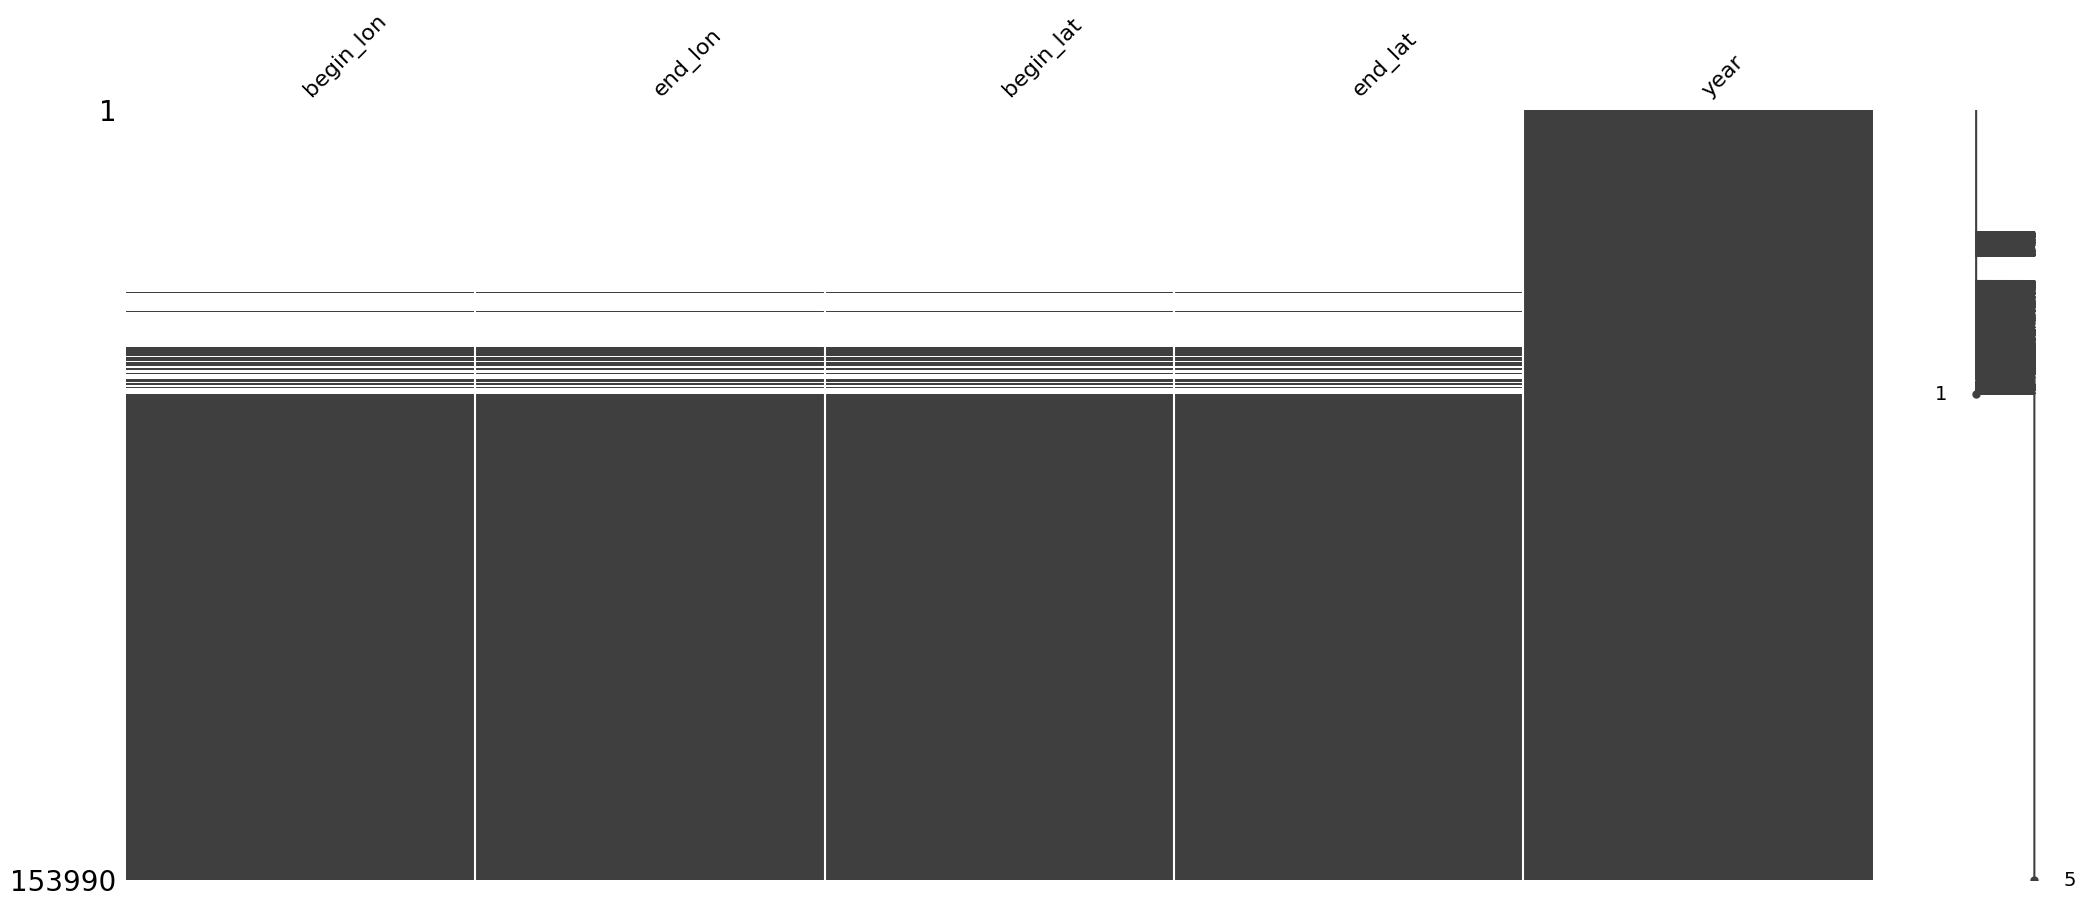

In [12]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'year']].sort_values('year'))

<Axes: >

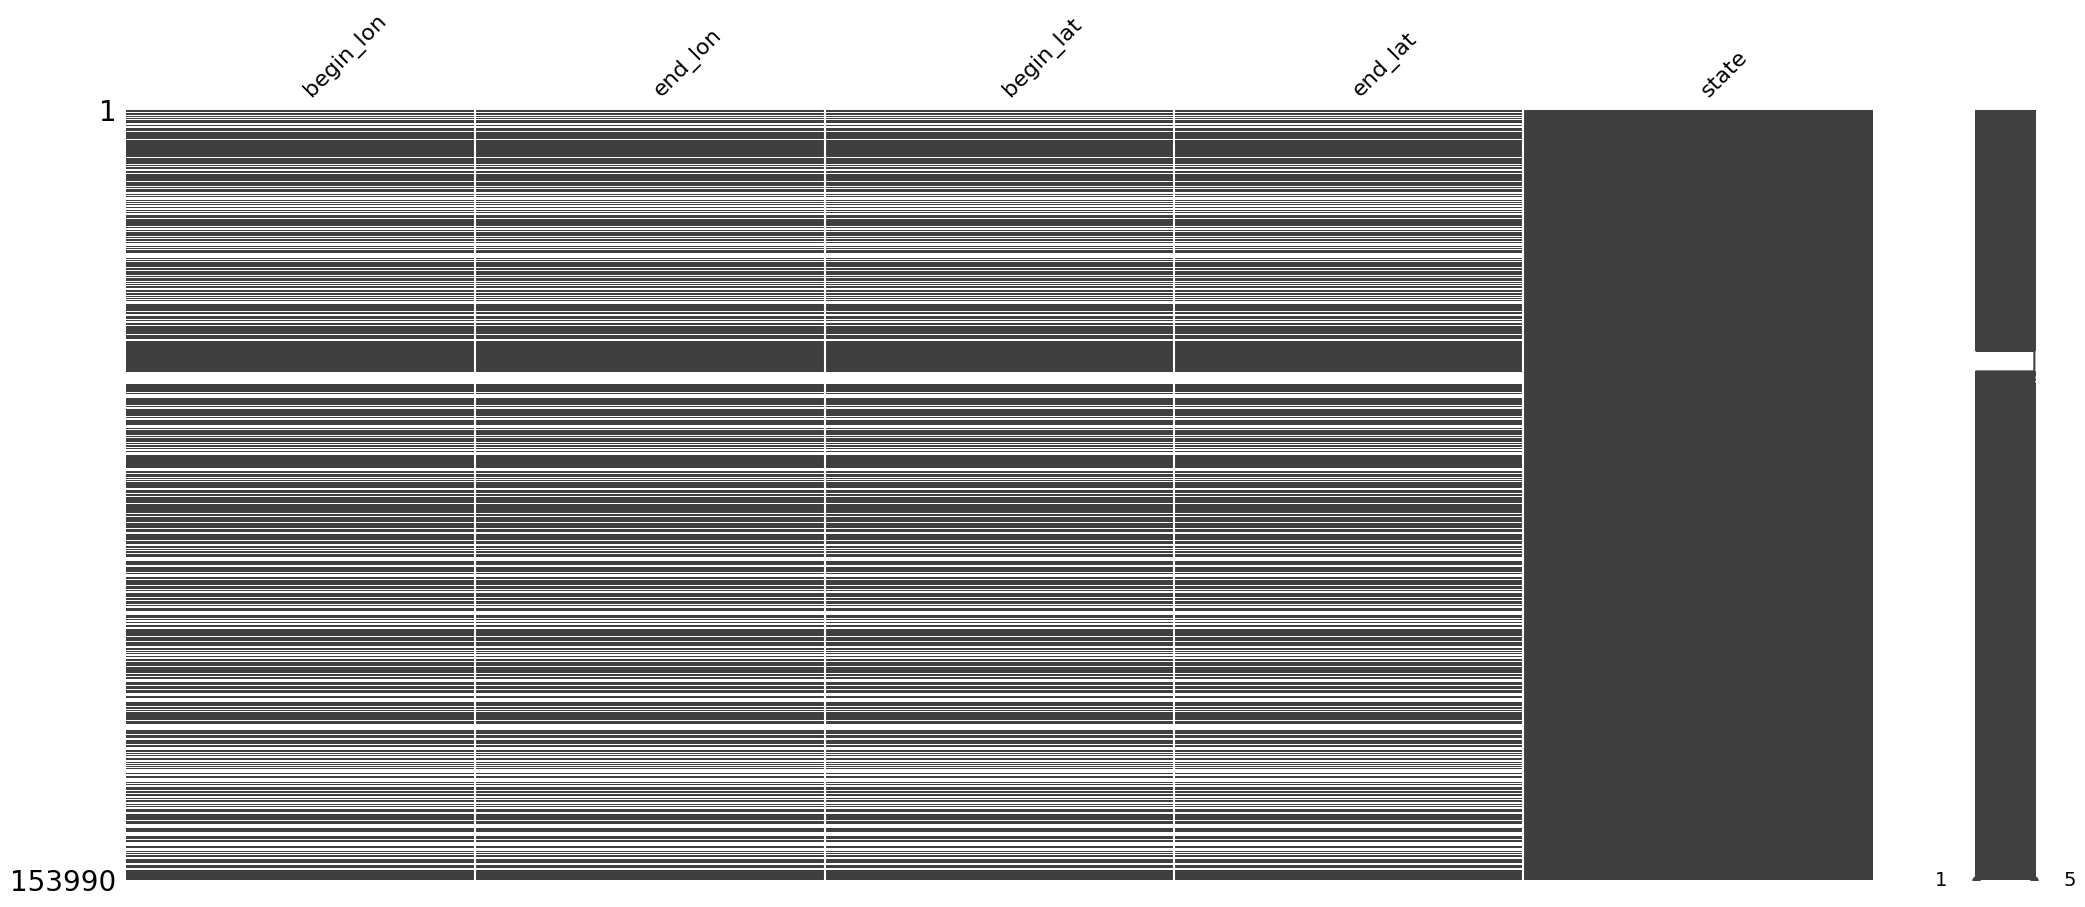

In [13]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'state']].sort_values('state'))

Missing lat/long for older data, not isolated to specific geographic locations. What percentage of each year is missing? 

In [14]:
df_missingloc = df_flood_drop.loc[df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1) == 4, :]
df_missingloc['year'].value_counts().sort_index()  / df_flood_drop.groupby('year').count()['event_id'] * 100

year
1996    100.000000
1997    100.000000
1998    100.000000
1999    100.000000
2000    100.000000
2001     96.596367
2002    100.000000
2003     95.012107
2004     96.599914
2005     24.605452
2006     63.469493
2007           NaN
2008           NaN
2009           NaN
2010           NaN
2011           NaN
2012           NaN
2013           NaN
2014           NaN
2015           NaN
2016           NaN
2017           NaN
2018           NaN
2019           NaN
2020           NaN
2021           NaN
dtype: float64

Looks like most missing data is in early years. We'll drop missing for now, but note the percentage of missing lat/long for 2001 - 2006 may make those years less helpful. Nan in 2007 on becuase no missing values. 

In [15]:

df_flood_drop2 = df_flood_drop.dropna(subset=['begin_lon', 'end_lon', 'begin_lat', 'end_lat'])
print('number floods before dropping missing locs:', len(df_flood_drop), 'number floods after dropping:', len(df_flood_drop2))

number floods before dropping missing locs: 153990 number floods after dropping: 103535


## Download shapefiles of each Census Tract

In [27]:
#import 2020 census zip code tabulation areas
file_list = pd.read_html('https://www2.census.gov/geo/tiger/TIGER2020/TRACT/')[0].loc[2:57, 'Name']
tracts = pd.DataFrame()
for filename in file_list:
    this_tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/TRACT/' + filename)
    # this_tract.index = this_tract['TRACTCE']
    tracts = pd.concat([tracts, this_tract])
    # print(tracts.shape)
tracts.head()

(85528, 13)


STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      01      045  020801  01045020801  208.01  Census Tract 208.01  G5020   
1      01      017  954200  01017954200    9542    Census Tract 9542  G5020   
2      01      017  953800  01017953800    9538    Census Tract 9538  G5020   
3      01      017  954300  01017954300    9543    Census Tract 9543  G5020   
4      01      017  954700  01017954700    9547    Census Tract 9547  G5020   

  FUNCSTAT      ALAND    AWATER     INTPTLAT      INTPTLON  \
0        S   19261326         0  +31.3971437  -085.6615959   
1        S   62998696     34641  +32.8341436  -085.2678516   
2        S  515692207  11516898  +33.0302580  -085.3867880   
3        S  132642536    178276  +32.7766468  -085.2734917   
4        S   38036820    264376  +32.7702191  -085.1744682   

                                            geometry  
0  POLYGON ((-85.70064 31.3851, -85.70043 31.3853...  
1  POLYGON ((-85.31549 32.8058, -85.31354 32.8088...  
2  POLYGON ((-85.59345 33.00012, -85.59333 33.000...  
3  POLYGON ((-85.38077 32.78301, -85.37985 32.782...  
4  POLYGON ((-85.22896 32.74543, -85.22894 32.745...

In [17]:
# Census TIGER files use NAD83
tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Create point geometry for each flood event, join with tract polygon. 

In [35]:
#### merge tract data to flood dataset
## create point geometry, use flood begin coordinates (puts event closer to flood source)
df_loc = pd.DataFrame([Point(str(x),str(y)) for x, y in zip(df_flood_drop2['begin_lon'], df_flood_drop2['begin_lat'])], columns=['locstr'])
df_loc.index = df_flood_drop2['event_id']

# convert to geodataframe with coordinate system WGS84, ie Lat/long
gdf_flood = gpd.GeoDataFrame(df_loc, geometry='locstr', crs='EPSG:4326')
gdf_flood.to_crs('EPSG:4269', inplace=True) #reproject to NAD83
gdf_tract = gpd.sjoin(gdf_flood, tracts, how='left')
print(gdf_tract.shape)
gdf_tract.head()

(103536, 14)


locstr  index_right STATEFP COUNTYFP TRACTCE  \
event_id                                                                     
5276096   POINT (-88.83333 35.61667)        876.0      47      113  000700   
5240447         POINT (-89.25 32.75)        751.0      28      099  940100   
5238548   POINT (-89.83333 31.41667)        571.0      28      065  950202   
5238549         POINT (-89.75 31.45)        572.0      28      065  950201   
5238551      POINT (-89.55 31.41667)        665.0      28      073  020101   

                GEOID     NAME              NAMELSAD  MTFCC FUNCSTAT  \
event_id                                                               
5276096   47113000700        7        Census Tract 7  G5020        S   
5240447   28099940100     9401     Census Tract 9401  G5020        S   
5238548   28065950202  9502.02  Census Tract 9502.02  G5020        S   
5238549   28065950201  9502.01  Census Tract 9502.01  G5020        S   
5238551   28073020101   201.01   Census Tract 201.01  G5020        S   

                ALAND     AWATER     INTPTLAT      INTPTLON  
event_id                                                     
5276096     2352646.0        0.0  +35.6215283  -088.8292753  
5240447   105020176.0   147638.0  +32.7880705  -089.2456666  
5238548   404792374.0  1238500.0  +31.4930936  -089.8814858  
5238549   241149697.0   410513.0  +31.5011243  -089.6792443  
5238551    87157380.0   150524.0  +31.4080651  -089.5973222

In [36]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')


In [168]:
##merge zip code back to flood data, remove events with missing zip code
# inner merge to keep only floods, don't need all tract geometry for this step (geometry only needed to map floods to census data)
df_flood_tract = df_flood_drop2.merge(gdf_tract[['TRACTCE', 'STATEFP', 'COUNTYFP']], how='inner', left_on='event_id', right_index=True)
df_flood_tract = df_flood_tract.dropna(subset='TRACTCE')
print(df_flood_tract.shape)
df_flood_tract.head()

(103468, 37)


begin_yearmonth  begin_day  begin_time  end_yearmonth  end_day  \
1426           200111         26        2100         200111       26   
7965           200104          4        1800         200104        4   
8121           200103          2        1530         200103        2   
8122           200103          2        1530         200103        2   
8124           200103          3         400         200103        3   

      end_time  episode_id  event_id        state state_fips  ...  begin_lat  \
1426      2300     1125447   5276096    TENNESSEE         47  ...   35.61667   
7965      2300     1113012   5240447  MISSISSIPPI         28  ...      32.75   
8121      1730     1112592   5238548  MISSISSIPPI         28  ...   31.41667   
8122      1800     1112592   5238549  MISSISSIPPI         28  ...      31.45   
8124       600     1112592   5238551  MISSISSIPPI         28  ...   31.41667   

      begin_lon   end_lat    end_lon episode_narrative  \
1426  -88.83333  35.61667  -88.83333               NaN   
7965     -89.25     32.75     -89.25               NaN   
8121  -89.83333  31.41667  -89.83333               NaN   
8122     -89.75     31.45     -89.75               NaN   
8124     -89.55  31.38333     -89.55               NaN   

                                        event_narrative data_source TRACTCE  \
1426  Several buildings had water in their basements...         PDS  000700   
7965  A significant flash flood event occurred due t...         PDS  940100   
8121  Localized flooding of roads occurred in wester...         PDS  950202   
8122  Localized flooding occurred on the streets in ...         PDS  950201   
8124            A few roads in the county had flooding.         PDS  020101   

     STATEFP COUNTYFP  
1426      47      113  
7965      28      099  
8121      28      065  
8122      28      065  
8124      28      073  

[5 rows x 37 columns]

In [40]:
##define census data variables to pull, and the data label
# variables: https://api.census.gov/data/2022/acs/acs5/variables.html

fields_dict = {'NAME': 'Name',
               # 'B19081_001E': 'houseinc_1',
               # 'B19081_002E': 'houseinc_2',
               # 'B19081_003E': 'houseinc_3',
               # 'B19081_004E': 'houseinc_4',
               # 'B19081_005E': 'houseinc_5',
               # 'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1', 
               'B19083_001E': 'gini',
               'B19081_001E': 'total_population',
               'B01001_002E': 'total_male', 
               'B01001_026E': 'total_female', 
               'B08303_001E': 'total_travel_time_to_work', 
               'B25105_001E': 'median_monthly_housing_costs', 
               
               'B25104_001E': 'total_monthlyHousingCosts', 
               'B25104_002E': 'total_HousingCosts_lessThan100', 
               # 'B25104_003E': 'total_HousingCosts_100To199', 
               # 'B25104_004E': 'total_HousingCosts_200To299', 
               # 'B25104_005E': 'total_HousingCosts_300TO399', 
               # 'B25104_006E': 'total_HousingCosts_400To499', 
               'B25104_007E': 'total_HousingCosts_500To599', 
               # 'B25104_008E': 'total_HousingCosts_600To699', 
               # 'B25104_009E': 'total_HousingCosts_700To799', 
               # 'B25104_010E': 'total_HousingCosts_800To899', 
               # 'B25104_011E': 'total_HousingCosts_900To999', 
               'B25104_012E': 'total_HousingCosts_1000To1499', 
               'B25104_013E': 'total_HousingCosts_1500To1999', 
               'B25104_014E': 'total_HousingCosts_2000To2499', 
               'B25104_015E': 'total_HousingCosts_2500To2999', 
               'B25104_016E': 'total_HousingCosts_3000OrMore', 
               # 'B25104_017E': 'total_HousingCosts_noCashRent', 
               
               'B01002_002E': 'median_age_male', 
               'B01002_003E': 'median_age_female', 
               
               # 'B15002_003E': 'education_noSchoolCompleted_maleOver25', 
               # 'B15002_020E': 'education_noSchoolCompleted_femaleOver25', 

               'B15003_017E': 'education_regularHSDiploma_over25',
               'B15003_018E': 'education_GEDAlt_over25',
               'B15003_019E': 'education_someCollegeLessThan1Yr_over25',
               'B15003_020E': 'education_someCollegeMoreThan1YrNoDegree_over25',
               'B15003_021E': 'education_associatesDegree_over25',
               'B15003_022E': 'education_BachelorsDegree_over25',
               'B15003_023E': 'education_mastersDegree_over25', 
               'B15003_024E': 'education_professionalSchoolDegree_over25', 
               'B15003_025E': 'education_doctorateDegree_over25', 

               'B18101_001E': 'male_35-64_withdisability',
               'B18101_032E': 'female_35-64_withdisability',
               'C16002_002E': 'householdLanguage_englishOnly', 
               'C16002_004E': 'householdLanguage_SpanishLimitedEnglish',
               'C16002_005E': 'householdLanguage_SpanishNotLimitedEnglish', 
               
               'C24050_002E': 'industry_agForestryEtc', 
               'C24050_003E': 'industry_construction', 
               'C24050_004E': 'industry_manufacturing', 
               'C24050_005E': 'industry_wholesaleTrade', 
               'C24050_006E': 'industry_retailTrade', 
               'C24050_007E': 'industry_transportationWarehousingUtilities', 
               'C24050_008E': 'industry_information', 
               'C24050_009E': 'industry_financeInsuranceRealEstate', 
               'C24050_010E': 'industry_professionalScientificManagementEtc', 
               'C24050_011E': 'industry_educationHealcareSocialAssistance', 
               'C24050_012E': 'industry_artsEntertainmentRecreationAccommodation',
               'C24050_013E': 'industry_otherServices', 
               'C24050_014E': 'industry_publicAdmin', 
               'C24050_015E': 'industry_managementBusinessScienceArts' 
              }

fields = ','.join(list(fields_dict.keys()))
names = list(fields_dict.values()) + ['state', 'county', 'tract']


In [169]:
### request data from api, put into dataframe

# loop through each state (Census tract data only downloaded by state)

#only lower 48
states_to_drop = ['GUAM', 'VIRGIN ISLANDS', 'DISTRICT OF COLUMBIA', 'HAWAII', 'ALASKA', 'AMERICAN SAMOA', 'PUERTO RICO']

#drop territories and alaska and hawaii, pull out unique fips code
state_fips_list = df_flood_tract.loc[~df_flood_tract['state'].isin(states_to_drop), 'state_fips'].unique()

df_census = pd.DataFrame()

for state in state_fips_list:
    url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=tract:*&in=state:' + str(state.zfill(2)) + ' county:*&key=' + API_KEY

    r_test = requests.get(url)
    r_test.json()
    this_df_census = pd.DataFrame(r_test.json()[1::], columns=names)
    df_census = pd.concat([df_census, this_df_census], ignore_index=True, axis=0)

print(df_census.shape)
df_census.head()

(83571, 50)


Name med_houseinc_12mon  \
0     Census Tract 201; Anderson County; Tennessee              40739   
1  Census Tract 202.01; Anderson County; Tennessee             103906   
2  Census Tract 202.02; Anderson County; Tennessee              68536   
3     Census Tract 203; Anderson County; Tennessee              67610   
4     Census Tract 204; Anderson County; Tennessee              62941   

  household_public_assistance1    gini total_population total_male  \
0                         1531  0.3936            10473       1453   
1                         2029  0.4327            25267       2162   
2                         1951  0.4561             7861       2410   
3                         1567  0.3719            18841       2012   
4                         1812  0.3840            16559       2240   

  total_female total_travel_time_to_work median_monthly_housing_costs  \
0         1726                      1206                          872   
1         2558                      1901                         1191   
2         2112                      1553                         1094   
3         2230                      1589                         1022   
4         2192                      1727                          933   

  total_monthlyHousingCosts  ... industry_financeInsuranceRealEstate  \
0                      1531  ...                                  65   
1                      2029  ...                                  71   
2                      1951  ...                                  49   
3                      1567  ...                                  72   
4                      1812  ...                                  37   

  industry_professionalScientificManagementEtc  \
0                                          239   
1                                          561   
2                                          257   
3                                          291   
4                                          370   

  industry_educationHealcareSocialAssistance  \
0                                        328   
1                                        432   
2                                        233   
3                                        311   
4                                        594   

  industry_artsEntertainmentRecreationAccommodation industry_otherServices  \
0                                                85                     52   
1                                               153                    152   
2                                                18                     84   
3                                               142                     93   
4                                               133                     42   

  industry_publicAdmin industry_managementBusinessScienceArts state county  \
0                   42                                    414    47    001   
1                  147                                   1264    47    001   
2                   64                                    592    47    001   
3                   41                                    589    47    001   
4                   24                                    836    47    001   

    tract  
0  020100  
1  020201  
2  020202  
3  020300  
4  020400  

[5 rows x 50 columns]

/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_2661/1165663743.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')


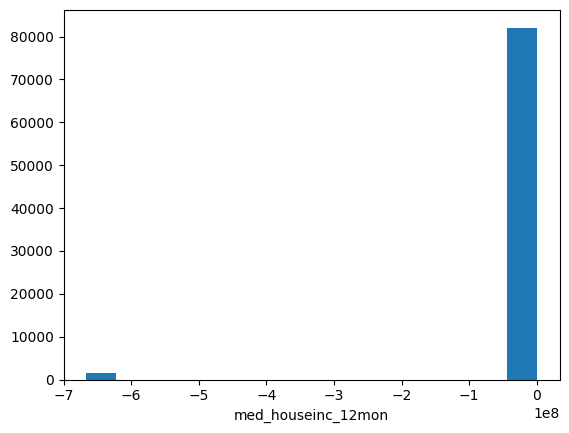

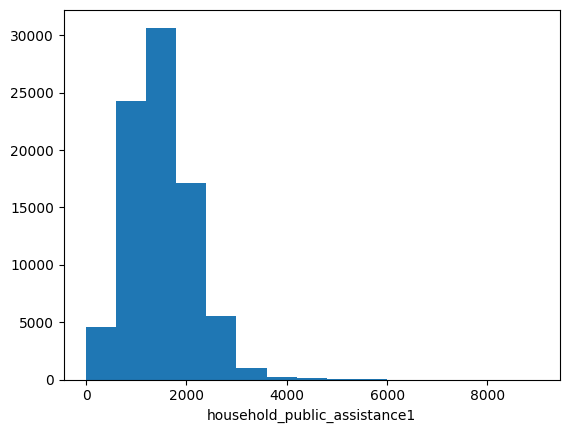

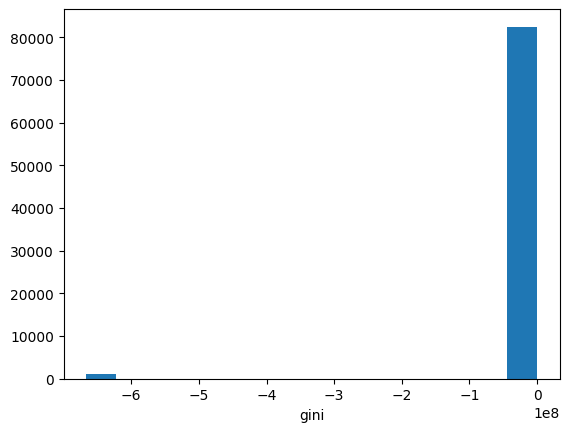

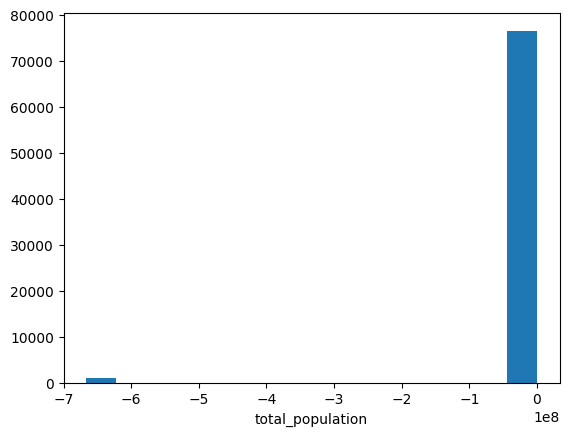

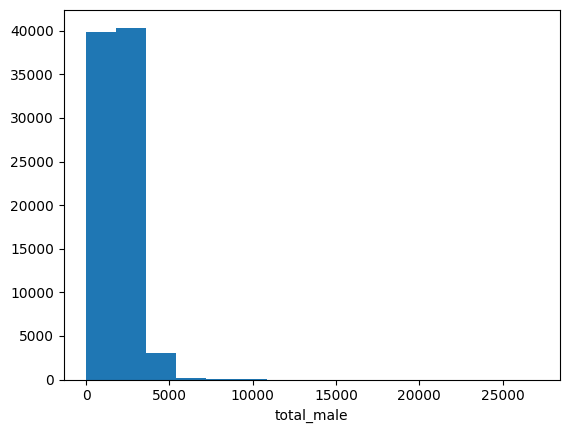

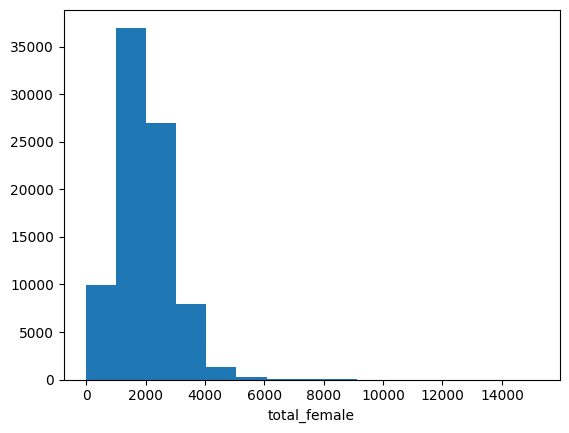

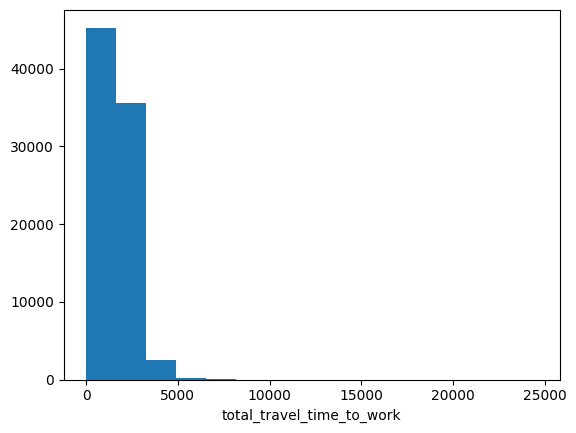

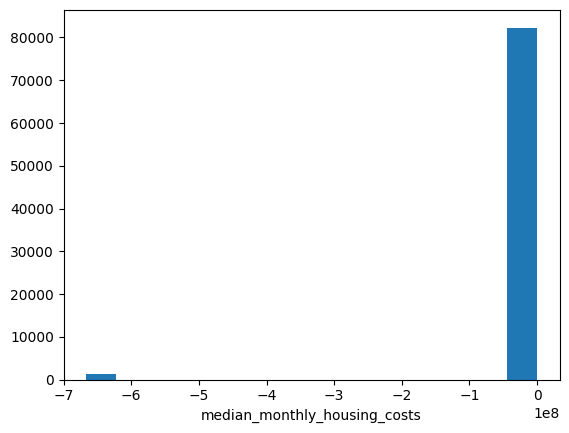

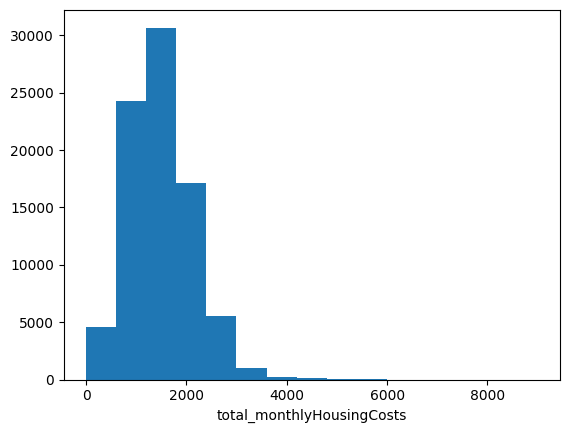

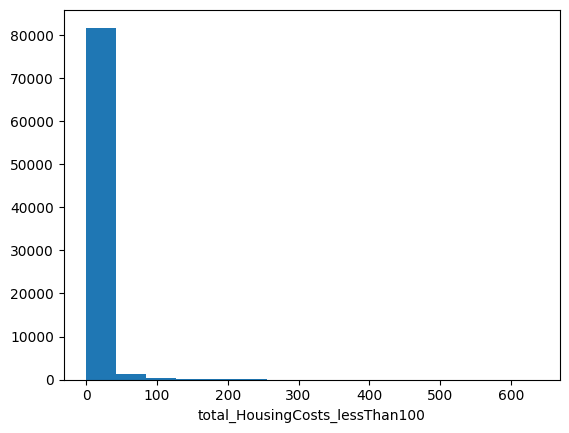

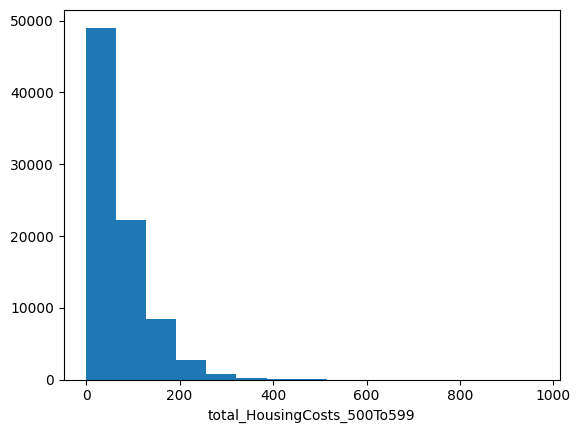

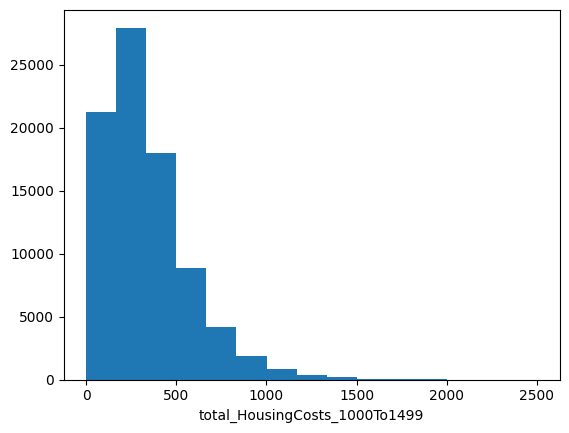

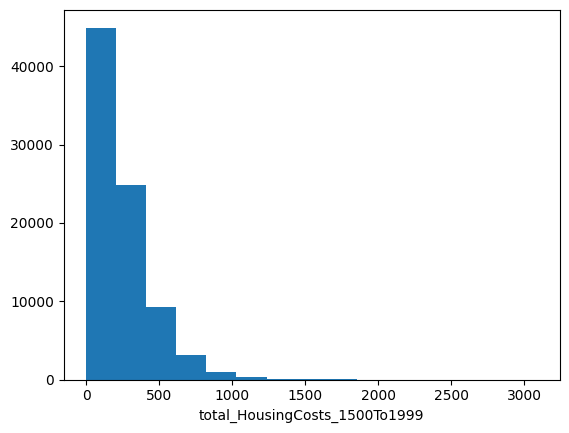

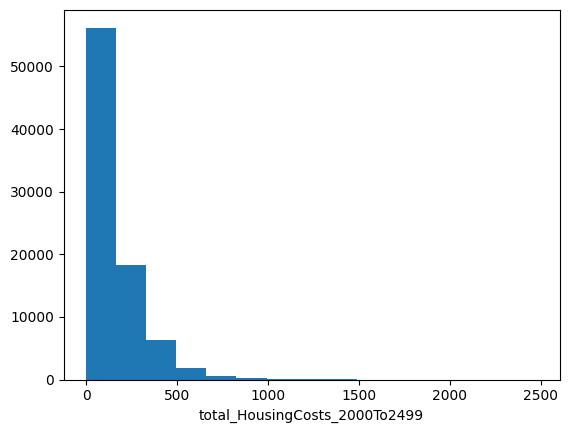

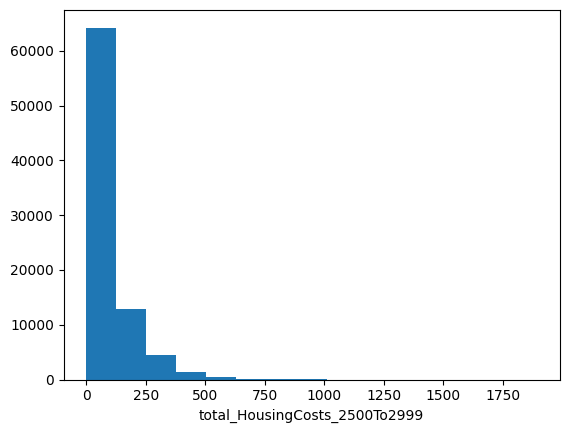

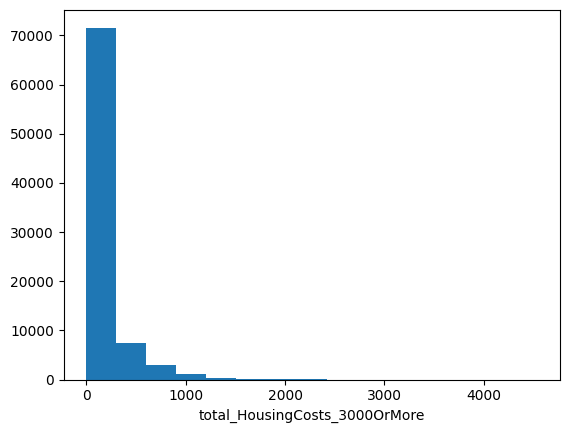

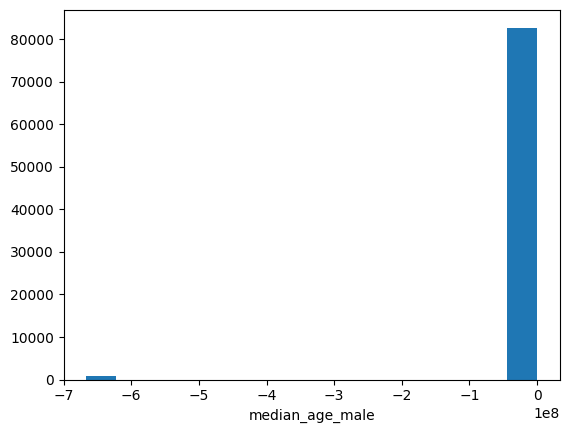

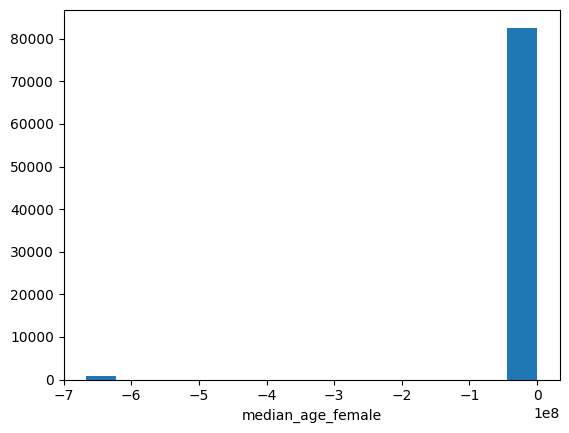

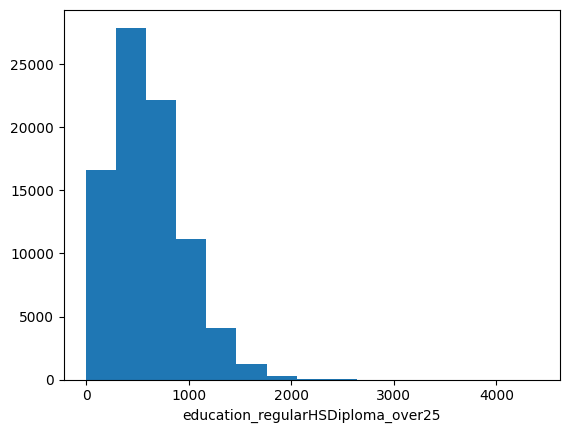

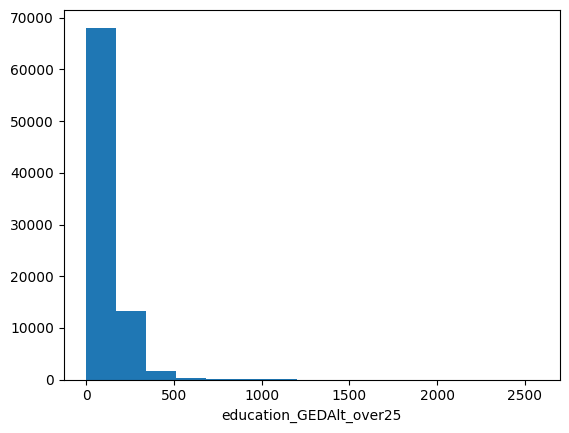

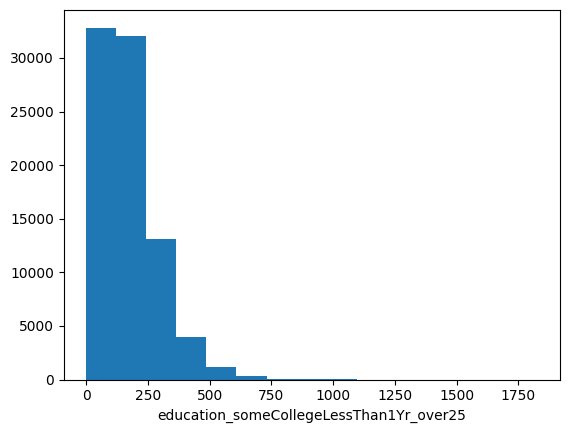

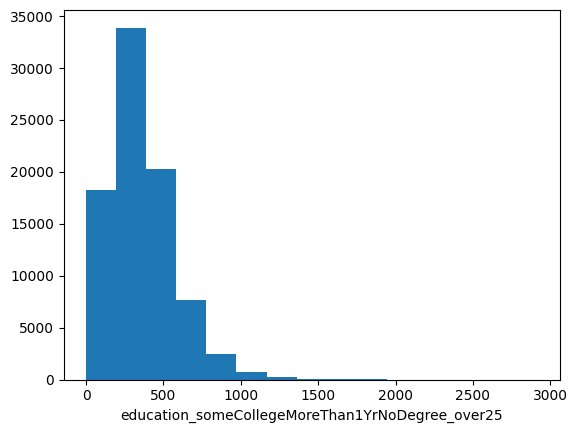

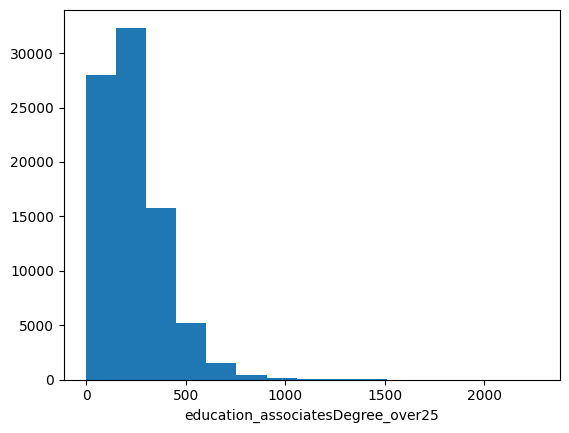

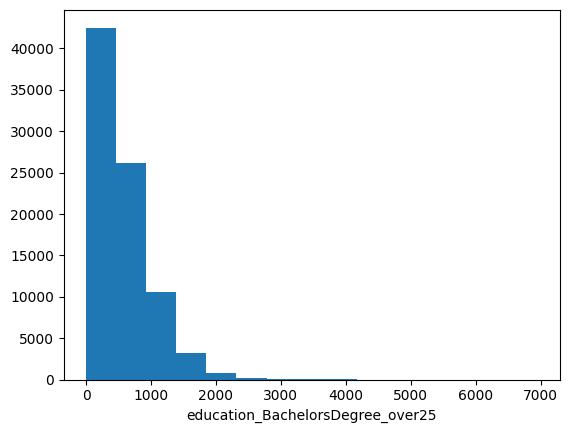

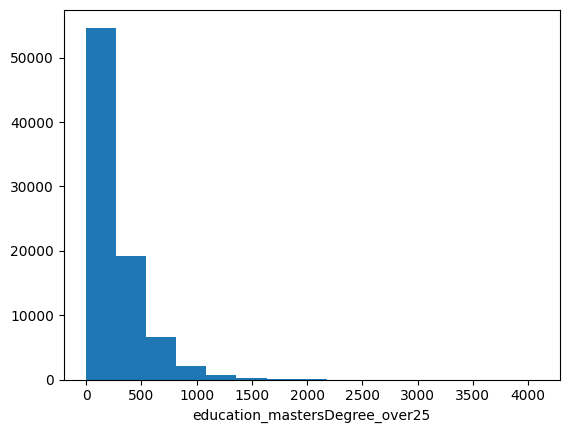

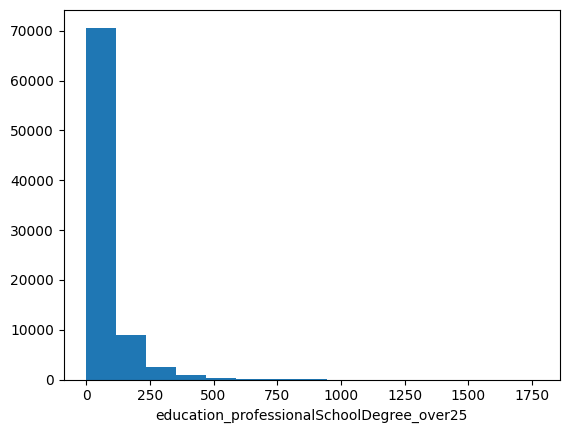

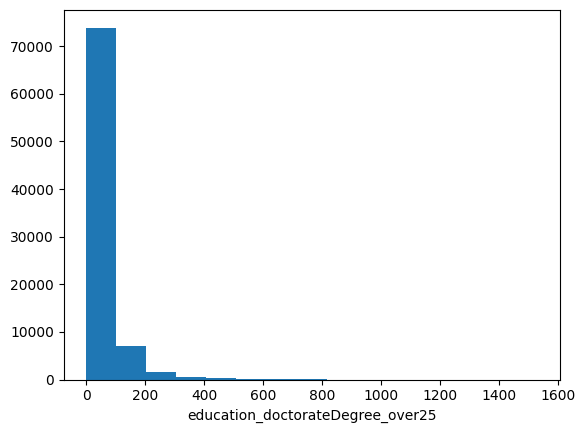

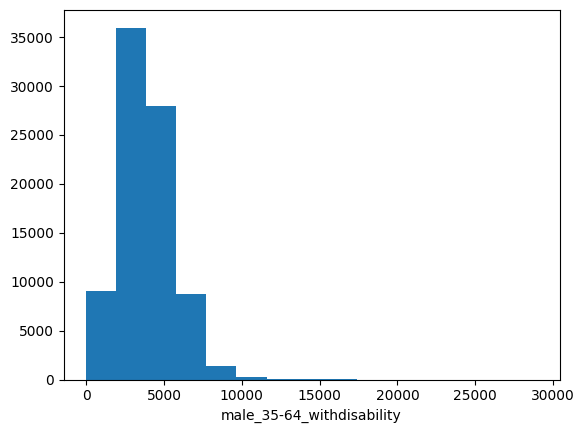

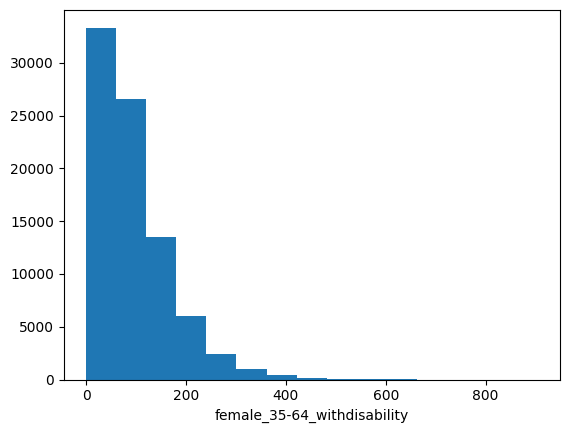

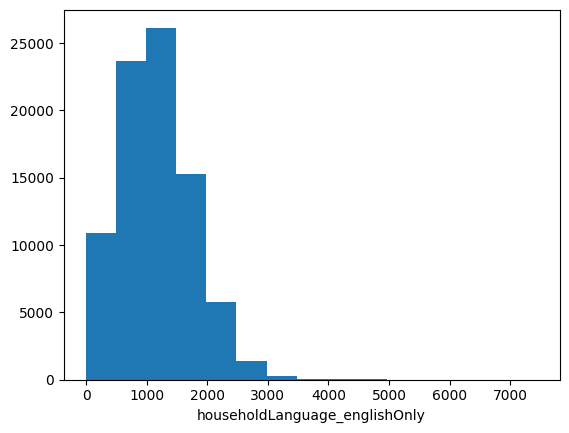

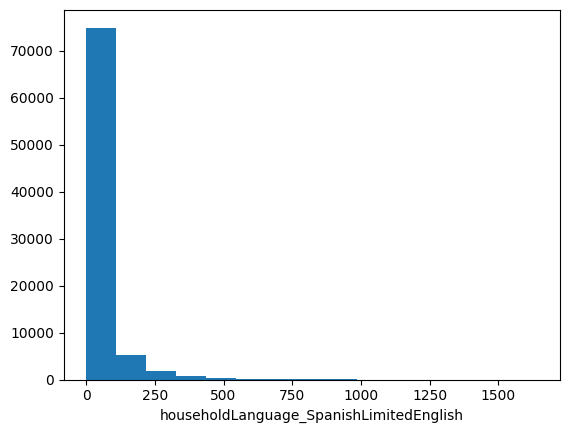

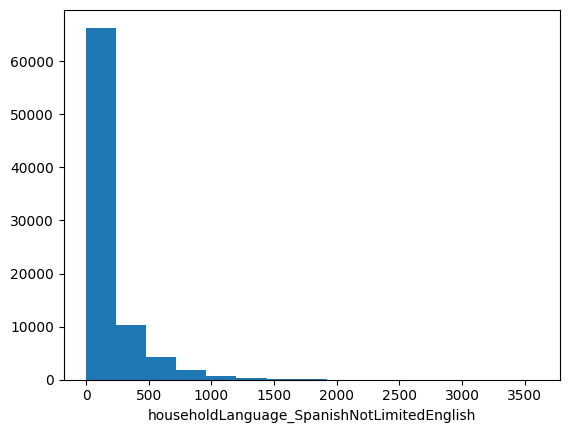

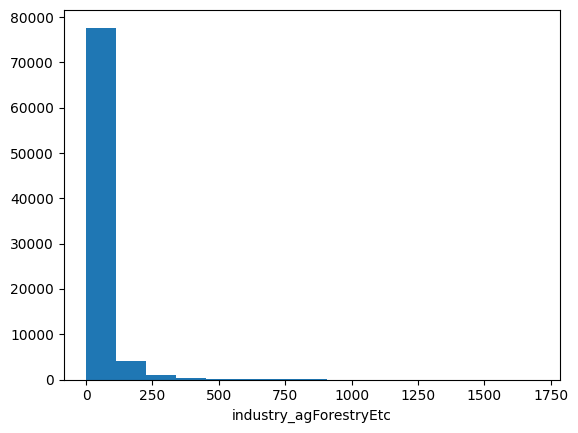

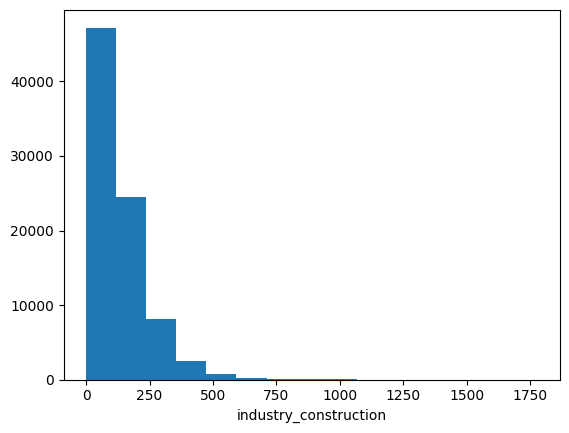

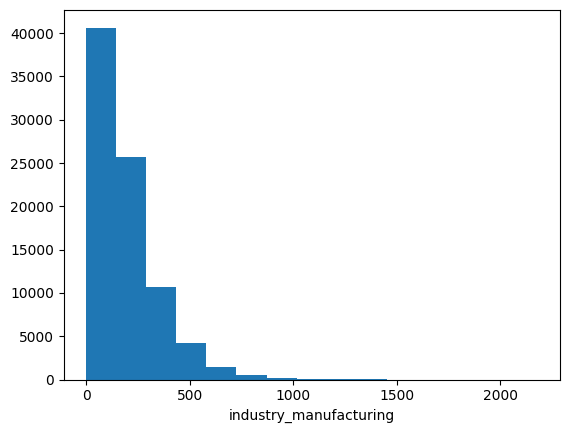

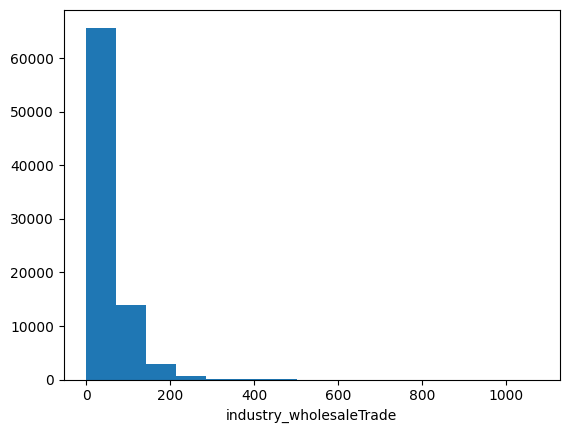

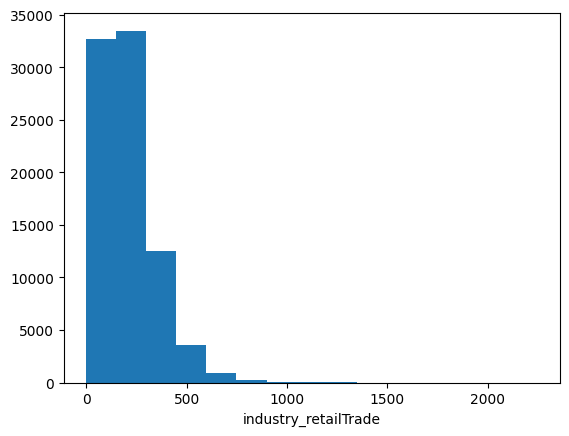

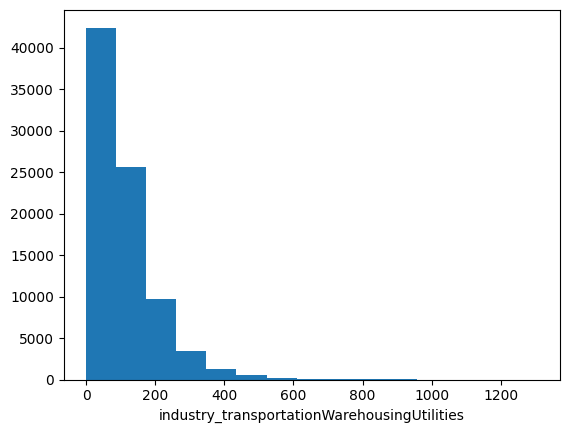

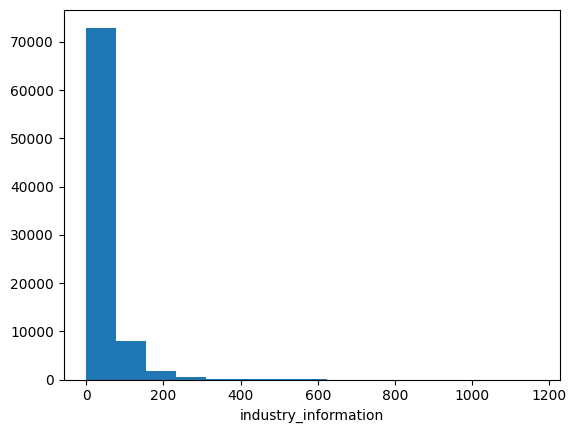

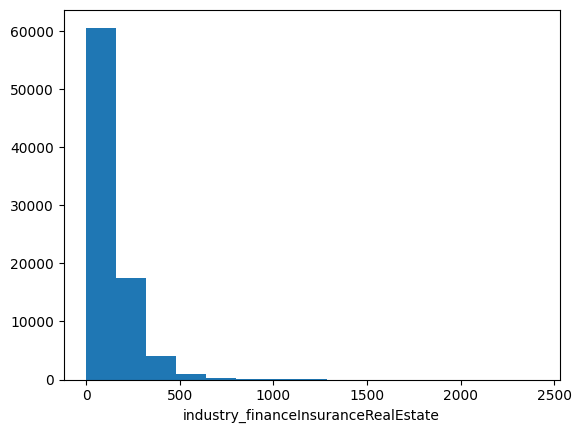

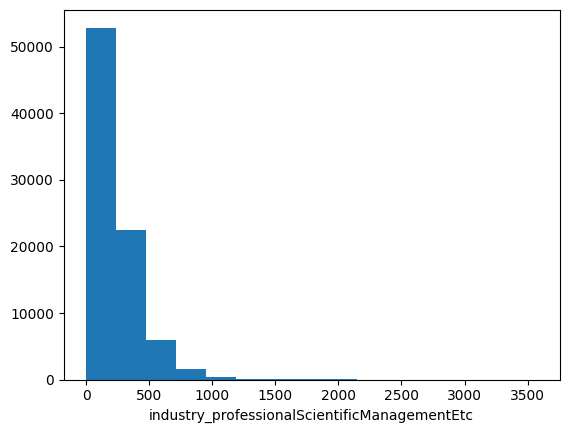

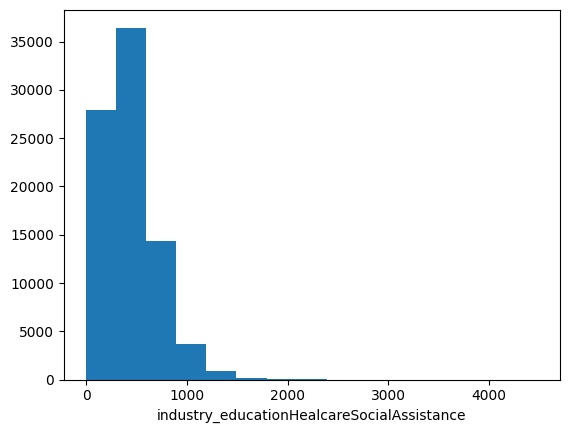

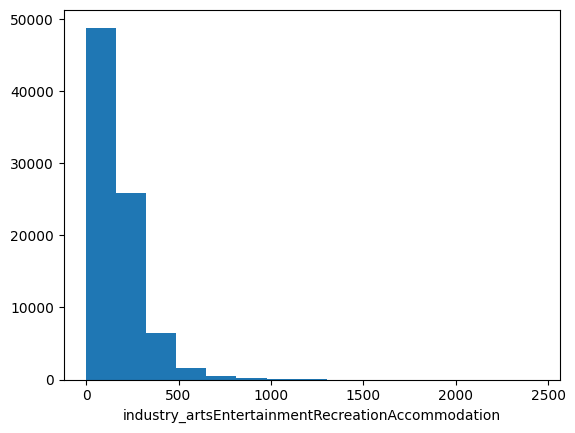

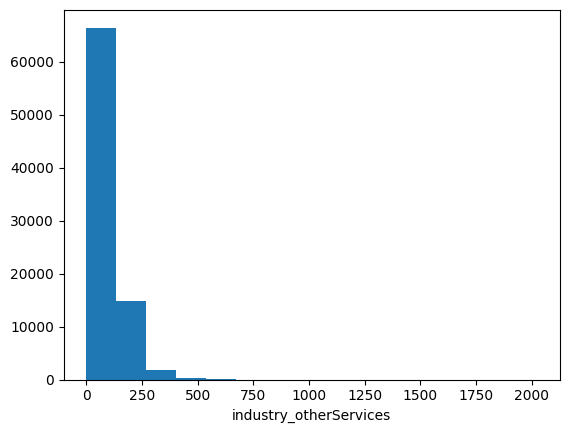

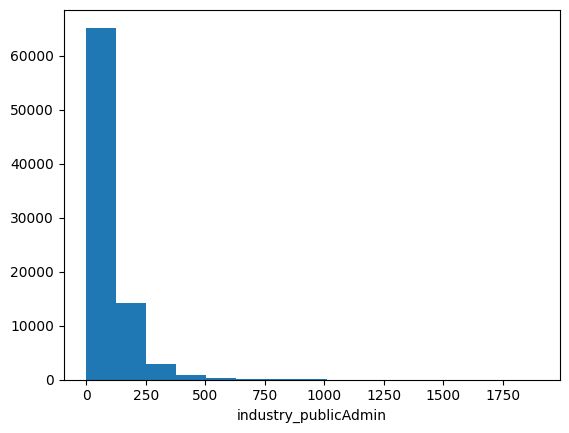

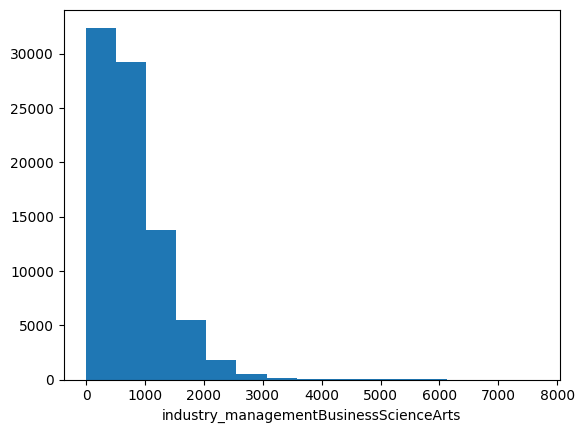

In [170]:
## check outliers

##check for outliers
df_census = df_census.replace(-666666666, np.nan)
census_numeric_names = df_census.columns.drop(['Name', 'state', 'county', 'tract'])

df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')

### check numeric outliers
for n in df_census[census_numeric_names].columns:
    plt.hist(df_census[census_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()

In [172]:
### merge census geography info w flood and census flood data
# keep all tracts and floods, including tracts with no floods

#make unique state-tract id on both dfs
df_census['tract_county_state'] = df_census['tract'] + '-' + df_census['county']+ '-' + df_census['state']
df_flood_tract['tract_county_state'] = df_flood_tract['TRACTCE'] + '-' + df_flood_tract['COUNTYFP'] + '-' + df_flood_tract['STATEFP']
# keep all tracts and floods
df_cen_fl_48 = df_census.merge(df_flood_tract, how='outer', left_on='tract_county_state', right_on='tract_county_state', validate='one_to_many') 
print('census data shape: ', df_census.shape)
print('census tracts without floods: ', df_cen_fl_48.loc[df_cen_fl_48['event_id'].isna()].shape)
print('flood data shape: ', df_flood_tract.shape)
print('floods without census tract match: ', df_cen_fl_48.loc[df_cen_fl_48['tract'].isna()].shape)


print('merged data shape: ', df_cen_fl_48.shape)

df_cen_fl_48.head().T

census data shape:  (83571, 51)
census tracts without floods:  (54527, 88)
flood data shape:  (103468, 38)
floods without census tract match:  (3159, 88)
merged data shape:  (157995, 88)


0  \
Name                          Census Tract 1; Adams County; Illinois   
med_houseinc_12mon                                           61595.0   
household_public_assistance1                                  2377.0   
gini                                                          0.4819   
total_population                                             16873.0   
...                                                              ...   
event_narrative                                                  NaN   
data_source                                                      NaN   
TRACTCE                                                          NaN   
STATEFP                                                          NaN   
COUNTYFP                                                         NaN   

                                                                              1  \
Name                                  Census Tract 1; Allegany County; Maryland   
med_houseinc_12mon                                                      56232.0   
household_public_assistance1                                             1577.0   
gini                                                                     0.3839   
total_population                                                        12003.0   
...                                                                         ...   
event_narrative               Flooding occurred along the banks of the C and...   
data_source                                                                 PDS   
TRACTCE                                                                  000100   
STATEFP                                                                      24   
COUNTYFP                                                                    001   

                                                                              2  \
Name                                  Census Tract 1; Allegany County; Maryland   
med_houseinc_12mon                                                      56232.0   
household_public_assistance1                                             1577.0   
gini                                                                     0.3839   
total_population                                                        12003.0   
...                                                                         ...   
event_narrative               A Trained Spotter reported flooding of Town Cr...   
data_source                                                                 CSV   
TRACTCE                                                                  000100   
STATEFP                                                                      24   
COUNTYFP                                                                    001   

                                                                              3  \
Name                                  Census Tract 1; Allegany County; Maryland   
med_houseinc_12mon                                                      56232.0   
household_public_assistance1                                             1577.0   
gini                                                                     0.3839   
total_population                                                        12003.0   
...                                                                         ...   
event_narrative               A trained spotter reported Route 144 (National...   
data_source                                                                 CSV   
TRACTCE                                                                  000100   
STATEFP                                                                      24   
COUNTYFP                                                                    001   

                                                                              4  
Name                                  Census Tract 1; Allegany County; Maryland  
med_houseinc_12mon                             

In [117]:

# add column to count floods
# event id is flood event, so null event_id is for tracts with no floods
df_cen_fl_48['flood_count'] = df_cen_fl_48['event_id'].apply(lambda x: 0 if np.isnan(x) else 1) 
# add seasonal flood count metrics
df_cen_fl_48['flood_count_fall'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['October', 'November', 'December'] else 0)
df_cen_fl_48['flood_count_winter'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['January', 'February', 'March'] else 0)
df_cen_fl_48['flood_count_spring'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['April', 'May', 'June'] else 0)



In [123]:
#check for missing data
print(len(df_cen_fl_48))
df_cen_fl_48.isna().sum().sort_values(ascending=False)


5884162


event_narrative                     385749
total_population                    369459
damage_crops                        314496
episode_narrative                   228059
damage_property                     221185
                                     ...  
education_doctorateDegree_over25       171
flood_count                              0
flood_count_fall                         0
flood_count_winter                       0
flood_count_spring                       0
Length: 89, dtype: int64

In [124]:
## narravtive column missing to be replaced with 'None' and No Info Available. 
## Text fields that will need to be converted somehow later anyway. 
df_cen_fl_48 = df_cen_fl_48.fillna({'episode_narrative': 'None', 'event_narrative': 'None', 
                                    'damage_property': 'No Info Available', 'damage_crops': 'No Info Available'
                                   })
# ##drop null values where household_public_assistance is missing
# df_final = df_cen_fl_48.dropna(subset='med_houseinc_12mon')
# print('final number of floods:', df_final['flood_count'].sum(), 'number of zip codes:', len(df_final))
# df_final.isna().sum()

Three categories of missing data. 
1. several census data metrics have missing data (total_population, med_houseinc_12mon, median_monthly_housing_costs, gini, median_age_male (female)) - keep for now, but will likely throw out later
2. 23k missing values for flood metrics, census tracts that don't have floods? 

In [131]:
df_cen_fl_48.loc[df_cen_fl_48['event_id'].isna(), :]

Name  \
240749            Census Tract 1.13; El Paso County; Texas   
240750    Census Tract 1.13; Bernalillo County; New Mexico   
240753    Census Tract 1.15; Bernalillo County; New Mexico   
240754   Census Tract 1.15; San Bernardino County; Cali...   
240755       Census Tract 1.15; Miami-Dade County; Florida   
...                                                    ...   
5884153      Census Tract 9903.01; Nassau County; New York   
5884154      Census Tract 9903.02; Nassau County; New York   
5884155         Census Tract 9904; Nassau County; New York   
5884160       Census Tract 9917.03; Dane County; Wisconsin   
5884161    Census Tract 9922.01; Island County; Washington   

         med_houseinc_12mon  household_public_assistance1    gini  \
240749              70472.0                        1180.0  0.3565   
240750              78396.0                        1520.0  0.4316   
240753              61250.0                        1702.0  0.3731   
240754              97990.0                        3004.0  0.5058   
240755              97847.0                         746.0  0.6021   
...                     ...                           ...     ...   
5884153                 NaN                           0.0     NaN   
5884154                 NaN                           0.0     NaN   
5884155                 NaN                           0.0     NaN   
5884160                 NaN                           0.0     NaN   
5884161                 NaN                           0.0     NaN   

         total_population  total_male  total_female  \
240749            13769.0      1470.0        1649.0   
240750            14988.0      1238.0        2041.0   
240753             6769.0      1444.0        1960.0   
240754             9424.0      3586.0        4982.0   
240755            20700.0       834.0         954.0   
...                   ...         ...           ...   
5884153               NaN         0.0           0.0   
5884154               NaN         0.0           0.0   
5884155               NaN         0.0           0.0   
5884160               NaN         0.0           0.0   
5884161               NaN         0.0           0.0   

         total_travel_time_to_work  median_monthly_housing_costs  \
240749                      1099.0                         827.0   
240750                      1172.0                        1103.0   
240753                      1648.0                         974.0   
240754                      3179.0                        2629.0   
240755                       717.0                        2324.0   
...                            ...                           ...   
5884153                        0.0                           NaN   
5884154                        0.0                           NaN   
5884155                        0.0                           NaN   
5884160                        0.0                           NaN   
5884161                        0.0                           NaN   

         total_monthlyHousingCosts  ...  end_lat  end_lon  episode_narrative  \
240749                      1180.0  ...      NaN      NaN               None   
240750                      1520.0  ...      NaN      NaN               None   
240753                      1702.0  ...      NaN      NaN               None   
240754                      3004.0  ...      NaN      NaN               None   
240755                       746.0  ...      NaN      NaN               None   
...                            ...  ...      ...      ...                ...   
5884153                        0.0  ...      NaN      NaN               None   
5884154                        0.0  ...      NaN      NaN               None   
5884155                        0.0  ...      NaN      NaN               None   
5884160                        0.0  ...      NaN      NaN               None   
5884161                        0.0  ...      NaN      NaN               None   

         event_narrative  data_source  TR

In [127]:
#check for missing data
print(len(df_cen_fl_48))
pd.set_option('display.max_rows', None)
display(df_cen_fl_48.isna().sum().sort_values(ascending=False))
pd.reset_option('display.max_rows')

5884162


total_population                                     369459
med_houseinc_12mon                                    70937
median_monthly_housing_costs                          64614
gini                                                  48240
median_age_female                                     40512
median_age_male                                       35165
state_y                                               23483
cz_type                                               23483
event_type                                            23483
month_name                                            23483
year                                                  23483
state_fips                                            23483
wfo                                                   23483
event_id                                              23483
cz_fips                                               23483
end_time                                              23483
end_day                                 

Some census data is just not available for certain zctas and variables. 
I was able to track down the specific reason these data were not available. 
More information available here: https://www.census.gov/programs-surveys/acs/technical-documentation/data-suppression.html

In [185]:
##check for duplicates
print('there are ', df_final.duplicated(subset=['zcta', 'event_id', 'year']).sum(), 'duplicates')

there are  0 duplicates


Data Transform steps to get ZTCA dataset: 
- Census data
- number of events since 1995
- number of events since 2010
- min, max, median event duration
- median income for state (to be able to account for state differences)
- delta flood
- number of floods by season

In [186]:
df_final['month_name'].unique()

array([nan, 'June', 'July', 'October', 'September', 'March', 'August',
       'February', 'January', 'May', 'December', 'April', 'November'],
      dtype=object)

In [193]:
### calculate number of events since certain year, and flood duration, compute dataset by zip code

names_to_keep = ['med_houseinc_12mon', 
                 'household_public_assistance1', 'gini', 'total_population']
names_to_sum = ['flood_count', 'flood_count_fall', 'flood_count_winter', 'flood_count_spring']
d1 = dict.fromkeys(names_to_keep, 'median')
d2 = dict.fromkeys(['state_fips'], 'first') ## keep first state fips as some zip codes have multiple states
d3 = dict.fromkeys(names_to_sum, 'sum')
df_final.loc[:, 'state_fips'] = df_final['state_fips']#.astype('int')

df_zcta = df_final[names_to_keep + names_to_sum + ['state_fips', 'zcta']].groupby('zcta').agg({**d1, **d2, **d3})
df_zcta.rename(columns={'flood_count': 'nflood_total'}, inplace=True)

## calculate decadal floods
df_zcta['nflood_2000s'] = df_final.loc[df_final['year'].between(2000, 2010, inclusive='left'), ['zcta', 'flood_count']].groupby('zcta').sum()
df_zcta['nflood_2010s'] = df_final.loc[df_final['year'].between(2010, 2020, inclusive='left'), ['zcta', 'flood_count']].groupby('zcta').sum()
#fill na with zero floods
df_zcta[['nflood_2000s', 'nflood_2010s']] = df_zcta[['nflood_2000s', 'nflood_2010s']].fillna(0, axis=1)

df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds) 
df_final['flood_duration'] = df_final['flood_duration'].fillna(0) # fill rows with no flood info with zero flood duration

df_zcta.loc[:,'flood_dur_hours_median'] = df_final[['zcta', 'flood_duration']].groupby('zcta').median() / 3660.0
df_zcta.loc[:,'flood_dur_hours_min'] = df_final[['zcta', 'flood_duration']].groupby('zcta').min() / 3660.0
df_zcta.loc[:,'flood_dur_hours_max'] = df_final[['zcta', 'flood_duration']].groupby('zcta').max() / 3660.0

df_zcta.head()


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_9574/4261165631.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds)
/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_9574/4261165631.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds)
/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_9574/4261165631.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy

med_houseinc_12mon  household_public_assistance1    gini  \
zcta                                                              
00611             22525.0                         523.0  0.5906   
00631             15658.0                         480.0  0.4674   
00775             25483.0                         447.0  0.4633   
00951             21354.0                         123.0  0.4437   
01001             73398.0                        6611.0  0.4308   

       total_population state_fips  nflood_total  flood_count_fall  \
zcta                                                                 
00611            1315.0       None             0                 0   
00631            1431.0       None             0                 0   
00775            1186.0       None             0                 0   
00951             298.0       None             0                 0   
01001           16045.0         25             3                 1   

       flood_count_winter  flood_count_spring  nflood_2000s  nflood_2010s  \
zcta                                                                        
00611                   0                   0           0.0           0.0   
00631                   0                   0           0.0           0.0   
00775                   0                   0           0.0           0.0   
00951                   0                   0           0.0           0.0   
01001                   0                   1           0.0           3.0   

       flood_dur_hours_median  flood_dur_hours_min  flood_dur_hours_max  
zcta                                                                     
00611                0.000000             0.000000             0.000000  
00631                0.000000             0.000000             0.000000  
00775                0.000000             0.000000             0.000000  
00951                0.000000             0.000000             0.000000  
01001                1.147541             1.032787             3.360656

In [194]:
#check missing values
df_zcta.isna().sum()

med_houseinc_12mon                  0
household_public_assistance1        0
gini                                0
total_population                    0
state_fips                      11013
nflood_total                        0
flood_count_fall                    0
flood_count_winter                  0
flood_count_spring                  0
nflood_2000s                        0
nflood_2010s                        0
flood_dur_hours_median              0
flood_dur_hours_min                 0
flood_dur_hours_max                 0
dtype: int64

In [195]:
##calculate state metrics, median income levels

names_state = ['med_houseinc_12mon', 
                 'household_public_assistance1', 'state_fips']
df_state = df_final[names_state].groupby('state_fips').median()
# df_zcta_state = df_zcta[['state_fips', 'nflood_total', 'nflood_2000s', 'nflood_2010s']].groupby('state_fips').median()
# df_state_merge1 = df_state.merge(df_zcta_state, how='outer', on='state_fips')
df_state.columns = [n + '_state_med' for n in df_state.columns] ##rename columns to merge

df_zcta['zcta'] = df_zcta.index.astype('str')
df_zcta_merged = df_zcta.merge(df_state, how='outer', on='state_fips')
df_zcta_merged.head().T

0         1         2  \
med_houseinc_12mon                       76683.0   55017.0   63521.0   
household_public_assistance1              4573.0    2927.0    1232.0   
gini                                       0.397    0.4291    0.3902   
total_population                         11737.0    8194.0    3391.0   
state_fips                                     1         1         1   
nflood_total                                   1         3         2   
flood_count_fall                               0         1         0   
flood_count_winter                             0         0         1   
flood_count_spring                             0         0         0   
nflood_2000s                                 1.0       2.0       0.0   
nflood_2010s                                 0.0       1.0       1.0   
flood_dur_hours_median                  1.967213  3.442623  3.196721   
flood_dur_hours_min                     1.967213  1.967213  1.967213   
flood_dur_hours_max                     1.967213  3.934426   4.42623   
zcta                                       35004     35005     35006   
med_houseinc_12mon_state_med             54230.0   54230.0   54230.0   
household_public_assistance1_state_med    4190.0    4190.0    4190.0   

                                               3         4  
med_houseinc_12mon                       81351.0   46730.0  
household_public_assistance1             10062.0    8149.0  
gini                                      0.3769    0.4832  
total_population                         27052.0   20406.0  
state_fips                                     1         1  
nflood_total                                   6         5  
flood_count_fall                               1         0  
flood_count_winter                             0         0  
flood_count_spring                             1         1  
nflood_2000s                                 1.0       2.0  
nflood_2010s                                 4.0       2.0  
flood_dur_hours_median                  2.459016  1.721311  
flood_dur_hours_min                     0.983607  0.983607  
flood_dur_hours_max                     8.852459  8.360656  
zcta                                       35007     35010  
med_houseinc_12mon_state_med             54230.0   54230.0  
household_public_assistance1_state_med    4190.0    4190.0

In [196]:
print(df_zcta_merged.isnull().sum())
### some of the n floods since date metrics returned no events and have a null, replace with zero

df_zcta_merged.fillna(0, inplace=True)
df_zcta_merged.isnull().sum()


med_houseinc_12mon                            0
household_public_assistance1                  0
gini                                          0
total_population                              0
state_fips                                11013
nflood_total                                  0
flood_count_fall                              0
flood_count_winter                            0
flood_count_spring                            0
nflood_2000s                                  0
nflood_2010s                                  0
flood_dur_hours_median                        0
flood_dur_hours_min                           0
flood_dur_hours_max                           0
zcta                                          0
med_houseinc_12mon_state_med              11013
household_public_assistance1_state_med    11013
dtype: int64


med_houseinc_12mon                        0
household_public_assistance1              0
gini                                      0
total_population                          0
state_fips                                0
nflood_total                              0
flood_count_fall                          0
flood_count_winter                        0
flood_count_spring                        0
nflood_2000s                              0
nflood_2010s                              0
flood_dur_hours_median                    0
flood_dur_hours_min                       0
flood_dur_hours_max                       0
zcta                                      0
med_houseinc_12mon_state_med              0
household_public_assistance1_state_med    0
dtype: int64

In [197]:
### save final data

df_final.to_csv('data/01_datawrangling_byflood_out.csv')
df_zcta_merged.to_csv('data/01_datawrangling_byzcta_out.csv')


<Axes: >

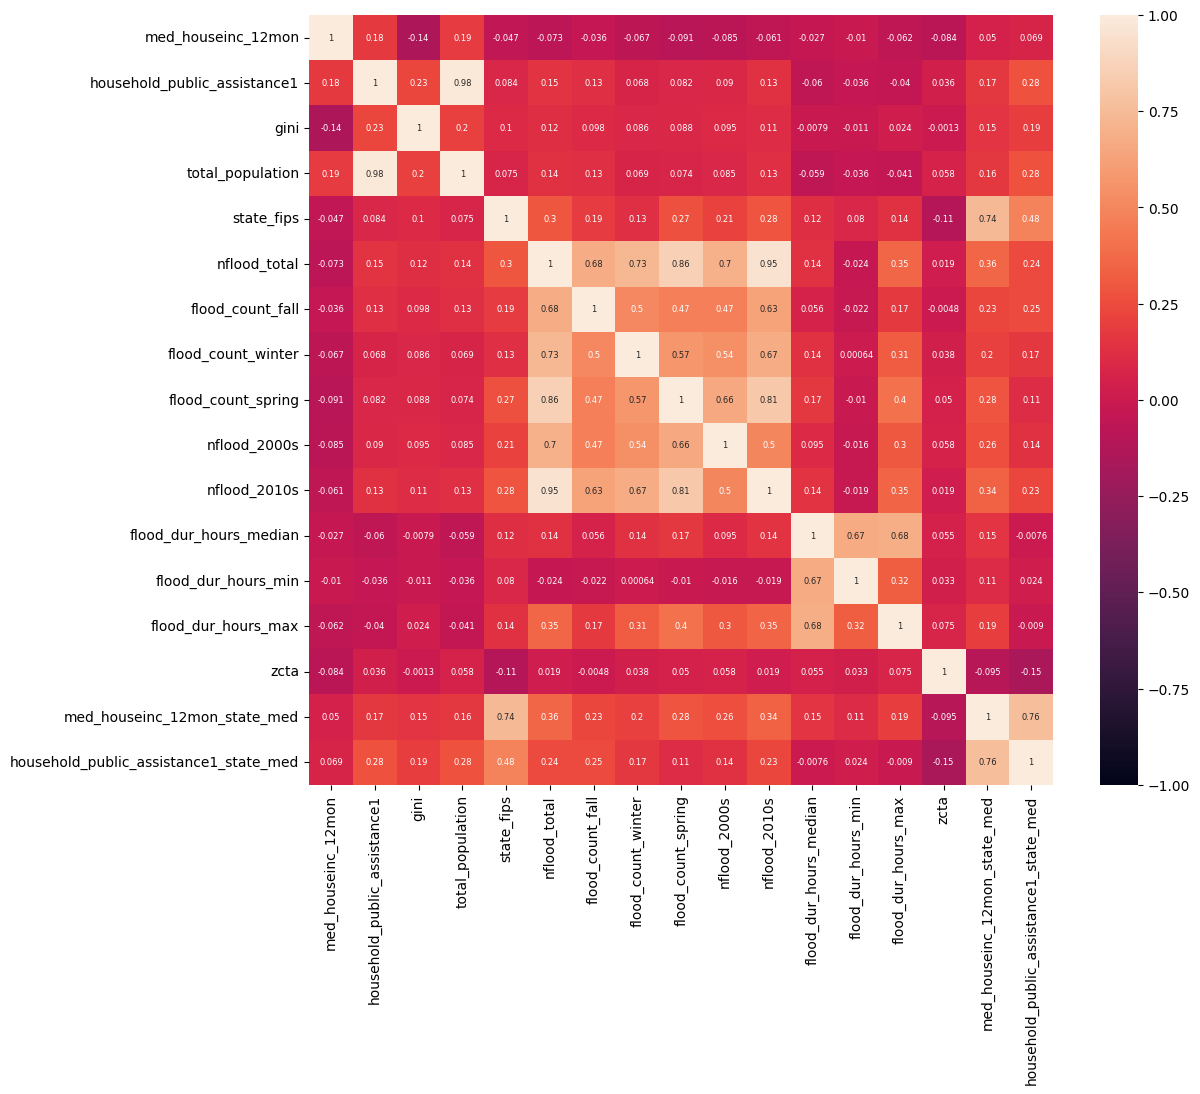

In [198]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(df_zcta_merged.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":6})

<Axes: >

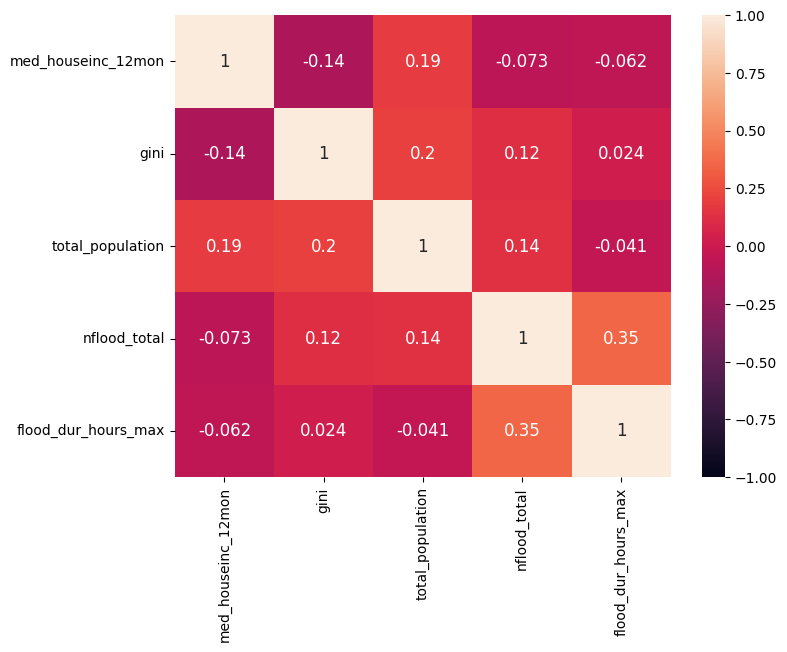

In [204]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(df_zcta_merged[['med_houseinc_12mon', 'gini', 'total_population', 'nflood_total', 'flood_dur_hours_max']].corr(), 
            vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":12})